In [1]:
import networkx as nx
import matplotlib.pyplot as plt

def draw_graph(G, node_names={}, node_size=500):
    pos_nodes = nx.spring_layout(G)
    nx.draw(G, pos_nodes, with_labels=True, node_size=node_size, edge_color='gray', arrowsize=30)
    
    pos_attrs = {}
    for node, coords in pos_nodes.items():
        pos_attrs[node] = (coords[0], coords[1] + 0.08)
        
    #nx.draw_networkx_labels(G, pos_attrs, font_family='serif', font_size=20)
    
    plt.axis('off')
    axis = plt.gca()
    axis.set_xlim([1.2*x for x in axis.get_xlim()])
    axis.set_ylim([1.2*y for y in axis.get_ylim()])
    plt.show()

# Similarity Based Methods

## Index Based

### Resource Allocation

[(1, 2, 0.5), (2, 5, 0.5), (3, 4, 0.5)]


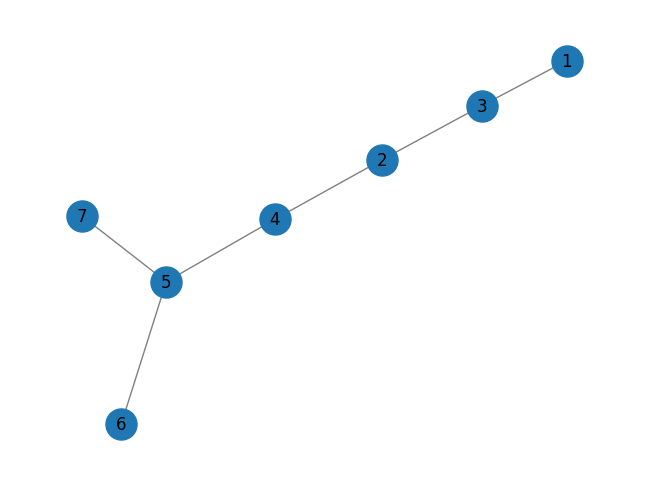

In [2]:
edges = [[1,3],[2,3],[2,4],[4,5],[5,6],[5,7]]
G = nx.from_edgelist(edges)
preds = nx.resource_allocation_index(G,[(1,2),(2,5),(3,4)])
print(list(preds))
draw_graph(G)

### Jaccard Coefficient

[(1, 2, 0.5), (2, 5, 0.25), (3, 4, 0.3333333333333333)]


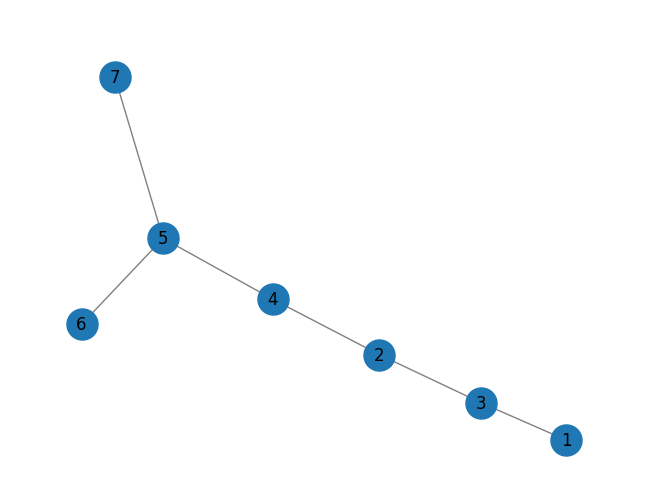

In [3]:
import networkx as nx
edges = [[1,3],[2,3],[2,4],[4,5],[5,6],[5,7]]
G = nx.from_edgelist(edges)
preds = nx.jaccard_coefficient(G,[(1,2),(2,5),(3,4)])
print(list(preds))
draw_graph(G)

## Community Based

### Community Common Neighbor

[(1, 2, 2), (2, 5, 1), (3, 4, 1)]


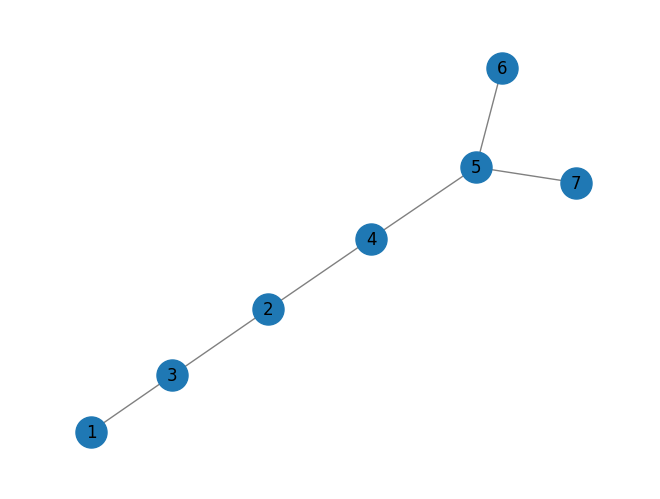

In [4]:
import networkx as nx
edges = [[1,3],[2,3],[2,4],[4,5],[5,6],[5,7]]
G = nx.from_edgelist(edges)

G.nodes[1]["community"] = 0
G.nodes[2]["community"] = 0
G.nodes[3]["community"] = 0

G.nodes[4]["community"] = 1
G.nodes[5]["community"] = 1
G.nodes[6]["community"] = 1
G.nodes[7]["community"] = 1
preds = nx.cn_soundarajan_hopcroft(G,[(1,2),(2,5),(3,4)])
print(list(preds))
draw_graph(G)

### Community Common Neighbor

[(1, 2, 0.5), (2, 5, 0), (3, 4, 0)]


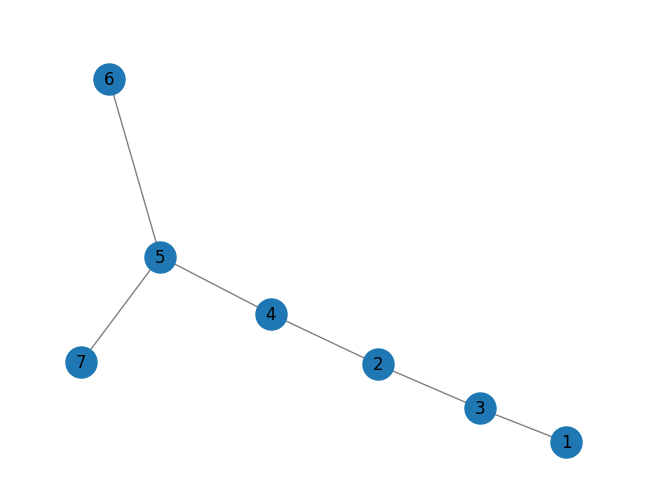

In [5]:
import networkx as nx
edges = [[1,3],[2,3],[2,4],[4,5],[5,6],[5,7]]
G = nx.from_edgelist(edges)

G.nodes[1]["community"] = 0
G.nodes[2]["community"] = 0
G.nodes[3]["community"] = 0

G.nodes[4]["community"] = 1
G.nodes[5]["community"] = 1
G.nodes[6]["community"] = 1
G.nodes[7]["community"] = 1
preds = nx.ra_index_soundarajan_hopcroft(G,[(1,2),(2,5),(3,4)])
print(list(preds))
draw_graph(G)

## Embedding based

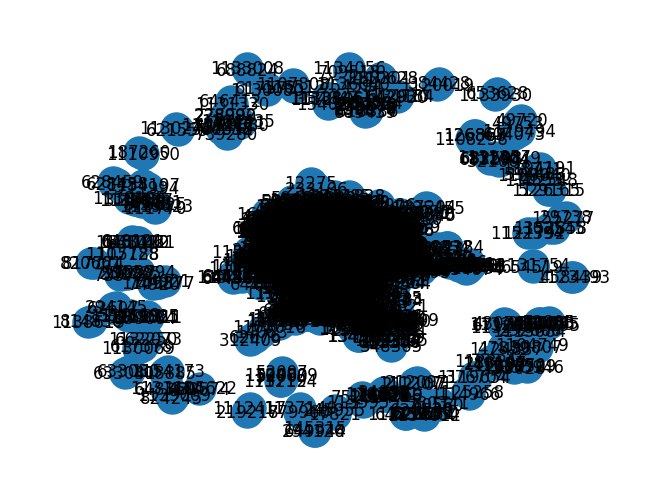

In [6]:
import networkx as nx
import pandas as pd

edgelist = pd.read_csv("cora/cora.cites", sep='\t', header=None, names=["target", "source"])
G = nx.from_pandas_edgelist(edgelist)
draw_graph(G)

In [7]:
from stellargraph.data import EdgeSplitter

edgeSplitter = EdgeSplitter(G)
graph_test, samples_test, labels_test = edgeSplitter.train_test_split(
    p=0.1, method="global"
)

2023-03-22 12:00:50.825981: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-22 12:00:50.826009: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


** Sampled 527 positive and 527 negative edges. **


2023-03-22 12:00:52.060045: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-03-22 12:00:52.060270: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-22 12:00:52.060290: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-22 12:00:52.060317: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (9d74f6962e2c): /proc/driver/nvidia/version does not exist
2023-03-22 12:00:52.060649: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

In [8]:
edgeSplitter = EdgeSplitter(graph_test, G)
graph_train, samples_train, labels_train = edgeSplitter.train_test_split(
    p=0.1, method="global"
)

** Sampled 475 positive and 475 negative edges. **


In [9]:
from node2vec import Node2Vec
from node2vec.edges import HadamardEmbedder

node2vec = Node2Vec(graph_train)
model = node2vec.fit()
edges_embs = HadamardEmbedder(keyed_vectors=model.wv)
train_embeddings = [edges_embs[str(x[0]),str(x[1])] for x in samples_train]

Generating walks (CPU: 1): 100%|██████████| 10/10 [01:19<00:00,  7.92s/it]


In [10]:
test_embeddings = [edges_embs[str(x[0]),str(x[1])] for x in samples_test]

In [11]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=1000)
rf.fit(train_embeddings, labels_train);

In [12]:
from sklearn import metrics

y_pred = rf.predict(test_embeddings)

print('Precision:', metrics.precision_score(labels_test, y_pred))
print('Recall:', metrics.recall_score(labels_test, y_pred))
print('F1-Score:', metrics.f1_score(labels_test, y_pred))

Precision: 0.8373493975903614
Recall: 0.7912713472485768
F1-Score: 0.8136585365853659
